In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

we are going to download images from google

In [44]:
folder = "black"
file = "urls_black.csv"

In [24]:
folder = "teddys"
file = "urls_teddys.csv"

In [39]:
folder = "grizzly"
file = "urls_grizzly.csv"

In [45]:
path = Path("data/bears")
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [46]:
path.ls()

[PosixPath('data/bears/teddys'),
 PosixPath('data/bears/black'),
 PosixPath('data/bears/grizzly')]

## Download images 

In [47]:
classes = ["teddys", "grizzly", "black"]

In [48]:
download_images(path/folder/file, dest, max_pics=200)

remove any images that can't be opened

In [52]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

In [53]:
np.random.seed(42)
data = ImageDataBunch.from_folder(
    path, train=".",
    valid_pct=0.2,
    ds_tfms=get_transforms(),
    size=224,
    num_workers=4).normalize(imagenet_stats)

In [54]:
data.classes

['black', 'grizzly', 'teddys']

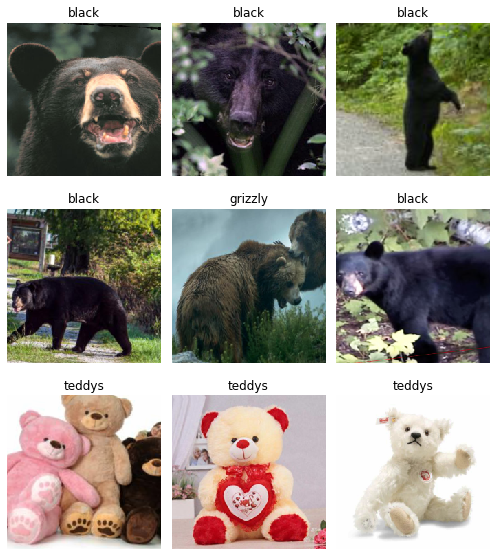

In [63]:
data.show_batch(rows=3, figsize=(7,8))

In [59]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['black', 'grizzly', 'teddys'], 3, 440, 109)

In [60]:
len(data.valid_ds)/len(data.train_ds)

0.24772727272727274

## Train model 

In [65]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [66]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.870144,0.200188,0.055046,00:04
1,0.507778,0.173601,0.036697,00:03
2,0.370897,0.168868,0.036697,00:03
3,0.302096,0.167187,0.045872,00:03


In [67]:
learn.save("stage-1")

In [68]:
learn.unfreeze()

In [69]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


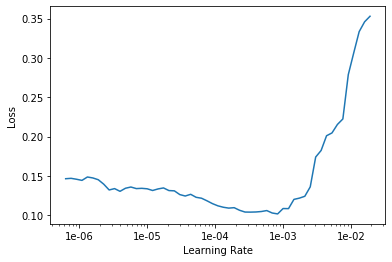

In [70]:
learn.recorder.plot()

rule of thumb is to find value of greates negative slope before increasing for the first layer and factor decrease by ten for remaining layers

In [71]:
learn.fit_one_cycle(2, max_lr=slice(4e-5, 4e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.130615,0.252169,0.036697,00:03
1,0.113718,0.199065,0.036697,00:03


In [72]:
learn.save("stage-2")

## Interpretation 

In [75]:
learn.load("stage-2");

In [76]:
interp = ClassificationInterpretation.from_learner(learn)

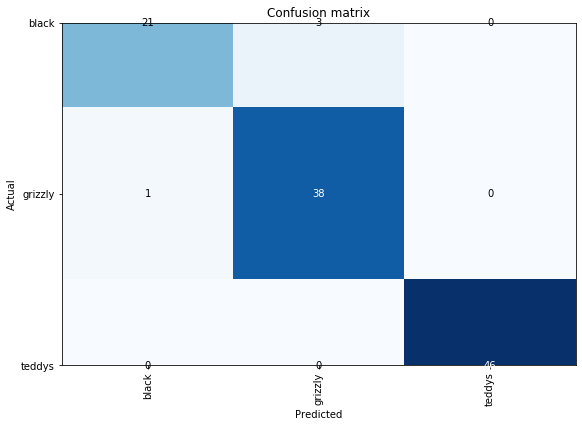

In [81]:
interp.plot_confusion_matrix(figsize=(8,9))

## Cleaning up 

In [82]:
from fastai.widgets import *

In [85]:
db = (ImageList.from_folder(path)
     .split_none()
     .label_from_folder()
     .transform(get_transforms(), size=224)
     .databunch()
     )

In [86]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)
learn_cln.load("stage-2");

In [87]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [88]:
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In [90]:
db = (ImageList.from_csv(path, "cleaned.csv", folder=".")
     .split_none()
     .label_from_folder()
     .transform(get_transforms(), size=224)
     .databunch()
     )

In [91]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)
learn_cln.load("stage-2");

In [92]:
ds, idxs = DatasetFormatter().from_similars(learn_cln)

Getting activations...


Computing similarities...


In [93]:
ImageCleaner(ds, idxs, path, duplicates=True)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

## Putting your model in production 

In [94]:
learn.export()

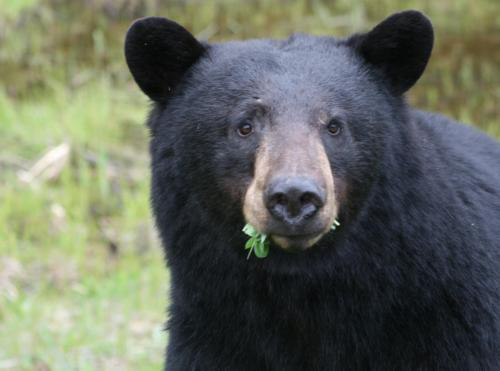

In [96]:
img = open_image(path/"black"/"00000032.jpg")
img

In [97]:
learn = load_learner(path)

In [98]:
path

PosixPath('data/bears')

In [100]:
pred_class, pred_idx, outputs = learn.predict(img)
pred_class

Category black

## Things that can go wrong 

In [101]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [102]:
learn.fit_one_cycle(1, max_lr=0.5)

epoch,train_loss,valid_loss,error_rate,time
0,15.251436,370229408.000000,0.779817,00:03


In [103]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [104]:
learn.fit_one_cycle(5, max_lr=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,1.266101,1.147953,0.669725,00:03
1,1.284826,1.031101,0.559633,00:03
2,1.290823,0.961650,0.449541,00:03
3,1.265020,0.929945,0.440367,00:03
4,1.255259,0.923705,0.440367,00:03


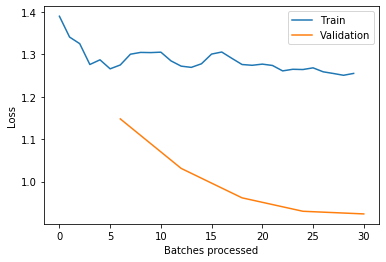

In [105]:
learn.recorder.plot_losses()

## Too few epochs

In [106]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [107]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.643894,0.157098,0.036697,00:03


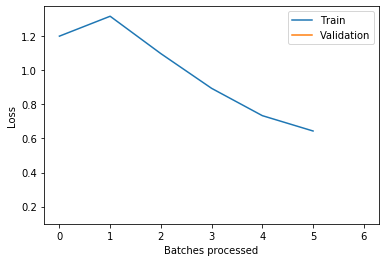

In [108]:
learn.recorder.plot_losses()

## Too many epochs 

In [109]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.9, bs=32, 
        ds_tfms=get_transforms(do_flip=False, max_rotate=0, max_zoom=1, max_lighting=0, max_warp=0
                              ),size=224, num_workers=4).normalize(imagenet_stats)

In [110]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate, ps=0, wd=0)
learn.unfreeze()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/ricky/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [01:16<00:00, 1336843.77it/s]


In [111]:
learn.fit_one_cycle(40, slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.436300,1.233152,0.647773,00:06
1,1.440441,1.205096,0.647773,00:03
2,1.416268,1.174566,0.623482,00:03
3,1.368001,1.136429,0.595142,00:03
4,1.332986,1.085285,0.546559,00:03
5,1.290420,1.023952,0.469636,00:03
6,1.262953,0.952147,0.408907,00:03
7,1.189477,0.867635,0.329960,00:03
8,1.107529,0.779217,0.269231,00:03
9,1.032720,0.691313,0.228745,00:03


## Linear Regression problem

In [6]:
from fastai.basics import *

In [7]:
n = 100

In [8]:
# pytorch methods that end with _ means perform inplace
x = torch.ones(n, 2)
x[:,0].uniform_(-1,1) # create random values between -1 1
x[:5]

tensor([[ 0.0138,  1.0000],
        [-0.0205,  1.0000],
        [ 0.8825,  1.0000],
        [-0.7457,  1.0000],
        [-0.2393,  1.0000]])

In [14]:
a = tensor(3., 2); a # decimal is used to enforce float not int

tensor([3., 2.])

In [23]:
a.type()

'torch.FloatTensor'

In [15]:
y = x@a + torch.rand(n) # add some random noise

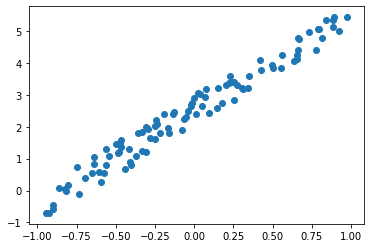

In [17]:
plt.scatter(x[:,0], y);

how do we find the coefficients 3 and 2?

In [18]:
def mse(y_hat, y):
    return ((y_hat - y)**2).mean()

In [19]:
a = tensor(-1., 1)

In [20]:
y_hat = x @ a
mse(y_hat, y)

tensor(6.2896)

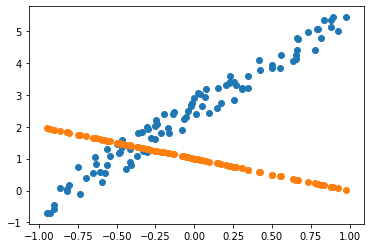

In [21]:
plt.scatter(x[:,0], y)
plt.scatter(x[:,0], y_hat)

## Gradient Descent 

In [22]:
a = nn.Parameter(a); a

Parameter containing:
tensor([-1.,  1.], requires_grad=True)

In [25]:
def update():
    y_hat = x@a
    loss = mse(y, y_hat)
    if t % 10 == 0: print(loss)
    loss.backward()
    with torch.no_grad():
        a.sub_(lr * a.grad) # subtract
        a.grad.zero_()      # zero out gradient

In [26]:
lr = 1e-1
for t in range(100): update()

tensor(6.2896, grad_fn=<MeanBackward0>)
tensor(1.5785, grad_fn=<MeanBackward0>)
tensor(0.5699, grad_fn=<MeanBackward0>)
tensor(0.2432, grad_fn=<MeanBackward0>)
tensor(0.1354, grad_fn=<MeanBackward0>)
tensor(0.0999, grad_fn=<MeanBackward0>)
tensor(0.0881, grad_fn=<MeanBackward0>)
tensor(0.0843, grad_fn=<MeanBackward0>)
tensor(0.0830, grad_fn=<MeanBackward0>)
tensor(0.0825, grad_fn=<MeanBackward0>)


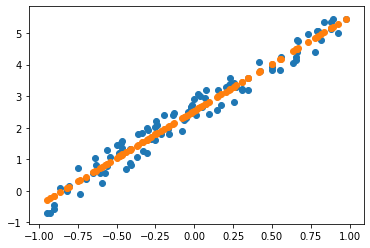

In [27]:
plt.scatter(x[:,0], y)
plt.scatter(x[:,0], x@a);

In [28]:
from matplotlib import animation, rc
rc("animation", html="jshtml")

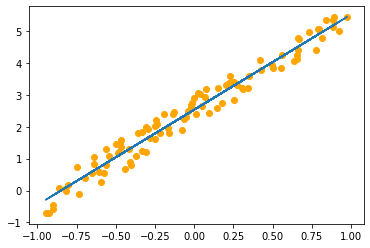

In [29]:
a = nn.Parameter(tensor(-1., 1))

fig = plt.figure()
plt.scatter(x[:,0], y, c="orange")
line, = plt.plot(x[:,0], x@a)

def animate(i):
    update()
    line.set_ydata(x@a)
    return line,

animation.FuncAnimation(fig, animate, np.arange(0, 100), interval=20)